In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model, standardize_dataset
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, MLP
from dev_losses import cauchy, rbf, gaussian_kernel, CustomSupCon, CustomContrastiveLoss
from losses import KernelizedSupCon

In [2]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat, hidden_dim_feat, output_dim, dropout_rate):
        super(MLP, self).__init__()
        
        self.feat_mlp = nn.Sequential(
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.BatchNorm1d(hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        # Xavier initialization
        self.init_weights(self.feat_mlp)

#         self.target_mlp = nn.Linear(input_dim_target, output_dim)
#         self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x):
        features = self.feat_mlp(x)
        features = nn.functional.normalize(features, p=2, dim=1)
        return features

In [5]:
class MatData(Dataset):
    def __init__(self, path_feat, path_targets, target_name):
        self.matrices = np.load(path_feat)
        self.target = pd.read_csv(path_targets)[target_name].values
    def __len__(self):
        return len(self.matrices)
    def __getitem__(self, idx):
        matrix = self.matrices[idx]
        target = self.target[idx]
        matrix = torch.from_numpy(matrix).float()
        target = torch.tensor(target, dtype=torch.float32)
        return matrix, target

In [6]:
def standardize_dataset(dataset):
    # Flatten the dataset across subjects and views to simplify standardization across features
    all_features_flat = torch.cat([dataset[i][0].view(-1, dataset[i][0].shape[-1]) for i in range(len(dataset))], dim=0)
    all_targets = torch.cat([dataset[i][1].unsqueeze(0) for i in range(len(dataset))], dim=0)
    
    # Calculate mean and std dev for each feature across all subjects and views
    features_mean = all_features_flat.mean(dim=0)
    features_std = all_features_flat.std(dim=0)
    
    # Ensure no division by zero
    features_std[features_std == 0] = 1
    
    # Initialize containers for standardized features
    standardized_features_list = []
    
    # Apply standardization to each sample
    for i in range(len(dataset)):
        features = dataset[i][0].view(-1, dataset[i][0].shape[-1])  # Flatten views for standardization
        standardized_features = (features - features_mean) / features_std
        standardized_features_list.append(standardized_features.view(dataset[i][0].shape))
    
    standardized_features = torch.stack(standardized_features_list)
    
    standardized_dataset = TensorDataset(standardized_features, all_targets)
    
    return standardized_dataset

In [7]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, kernel: callable=None, delta_reduction: str='sum', krnl_sigma: float = 1.):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.delta_reduction = delta_reduction
        self.krnl_sigma = krnl_sigma

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_features]. 
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 2:
            raise ValueError('`features` needs to be [bsz, n_feats], '
                            '2 dimensions are required')

        batch_size = features.shape[0]

        if labels is not None:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T).float()
            else:
                mask = self.kernel(labels, self.krnl_sigma)

        else:
            mask = torch.eye(batch_size, device=device)

        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # apply mask for positive samples, excluding self-contrast cases
        inv_diagonal = torch.eye(batch_size, device=device) * -1 + 1

        # base case: alignment
        alignment = logits

        # base case for uniformity: exp(logits) * inverse diagonal mask
        uniformity = torch.exp(logits) * inv_diagonal

        # Compute uniformity based on the method
        if self.method == 'threshold':
            # irrelevant for now
            pass
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))
        positive_mask = mask * inv_diagonal
        log_prob = alignment - uniformity  # log(alignment/uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1)  # mean log-likelihood over positives

        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

In [8]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi))

def gaussian_kernel_original(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

In [9]:
dataset = MatData("vectorized_matrices.npy", "participants.csv", "age")

In [10]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size = 0.2, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [11]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
# the rest is arbitrary
hidden_dim_feat = 1000
output_dim = 2

num_epochs = 100

lr = 0.001 # too low values return nan loss
kernel = cauchy
batch_size = 30 # too low values return nan loss
dropout_rate = 0.1
weight_decay = 0

In [12]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [32]:
torch.cuda.empty_cache()
model = MLP(input_dim_feat, hidden_dim_feat, output_dim, dropout_rate = dropout_rate).to(device)
criterion_pft = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.03, kernel=kernel, krnl_sigma = 1)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        out_feat = model(features)
        loss = criterion_pft(out_feat, targets)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')



Epoch 0 | Mean Loss 27.04153347015381
Epoch 1 | Mean Loss 6.8915340614318845
Epoch 2 | Mean Loss 3.6888776206970215
Epoch 3 | Mean Loss 3.4336565589904784
Epoch 4 | Mean Loss 3.3901003932952882
Epoch 5 | Mean Loss 3.3822147274017333
Epoch 6 | Mean Loss 3.377202558517456
Epoch 7 | Mean Loss 3.3717380428314208
Epoch 8 | Mean Loss 3.3721376037597657
Epoch 9 | Mean Loss 3.3655027866363527
Epoch 10 | Mean Loss 3.36833101272583
Epoch 11 | Mean Loss 3.3699065685272216
Epoch 12 | Mean Loss 3.36777419090271
Epoch 13 | Mean Loss 3.3680485820770265
Epoch 14 | Mean Loss 3.367183246612549
Epoch 15 | Mean Loss 3.362430438995361
Epoch 16 | Mean Loss 3.364509334564209
Epoch 17 | Mean Loss 3.3646661472320556
Epoch 18 | Mean Loss 3.36051549911499
Epoch 19 | Mean Loss 3.363410139083862
Epoch 20 | Mean Loss 3.3603389358520506
Epoch 21 | Mean Loss 3.361736717224121
Epoch 22 | Mean Loss 3.3613786602020266
Epoch 23 | Mean Loss 3.3578221225738525
Epoch 24 | Mean Loss 3.35815806388855
Epoch 25 | Mean Loss 3.35

## Evaluation

In [33]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing

@torch.no_grad()
def gather_age_feats(model, dataloader, device):
    features = []
    age_labels = []

    model.eval()
    for idx, (mat, labels) in enumerate(dataloader):
        if isinstance(mat, list):
            mat = mat[0]
        mat = mat.to(device)
        features.append(model(mat))
        age_labels.append(labels)
    
    return torch.cat(features, 0).cpu().numpy(), torch.cat(age_labels, 0).cpu().numpy()

@torch.no_grad()
def estimate_age(model, train_loader, test_loader, device):
    age_estimator = AgeEstimator()
    X_train, y_train = gather_age_feats(model, train_loader, device)
    age_estimator.fit(X_train, y_train)
    y_pred_train = age_estimator.predict(X_train)
    X_test, y_test = gather_age_feats(model, test_loader, device)
    y_pred_test = age_estimator.predict(X_test)
    return y_train, y_test, y_pred_train, y_pred_test

@torch.no_grad()
def compute_age_mae_r2(model, train_loader, test_loader, device): # test_int, test_ext, opts
    age_estimator = AgeEstimator()

    print("Training age estimator")
    train_X, train_y = gather_age_feats(model, train_loader, device)
    mae_train, r2_train = age_estimator.fit(train_X, train_y)
    X_test, y_test = gather_age_feats(model, test_loader, device)
    #ext_X, ext_y = gather_age_feats(model, test_ext, opts)
    mae_test = age_estimator.score(X_test, y_test)
    r2_test = age_estimator.r2(X_test, y_test)
    # mae_ext = age_estimator.score(ext_X, ext_y)

    return mae_train, r2_train, mae_test, r2_test # mae, r2 for train and test

class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [34]:
age_train, age_test, age_pred_train, age_pred_test = estimate_age(model, std_train_loader, std_test_loader, device)


X_train, y_train = gather_age_feats(model, std_train_loader, device)
X_test, y_test = gather_age_feats(model, std_test_loader, device)

df_train = pd.DataFrame({"Y_Train":age_train, "Y_Train_Pred":age_pred_train})
df_test = pd.DataFrame({"Y_Test": age_test, "Y_Test_Pred":age_pred_test})



/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


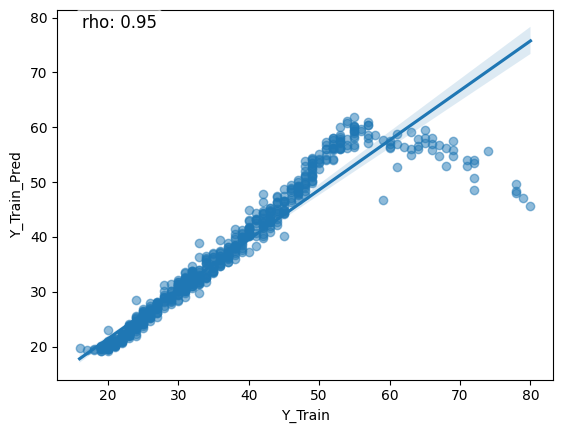

In [35]:

corr, _ = pearsonr(df_train['Y_Train'], df_train['Y_Train_Pred'])
corr_text = f'rho: {corr:.2f}'
sns.regplot(x='Y_Train', y='Y_Train_Pred', data=df_train, scatter_kws={'alpha':0.5})
plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
plt.show()

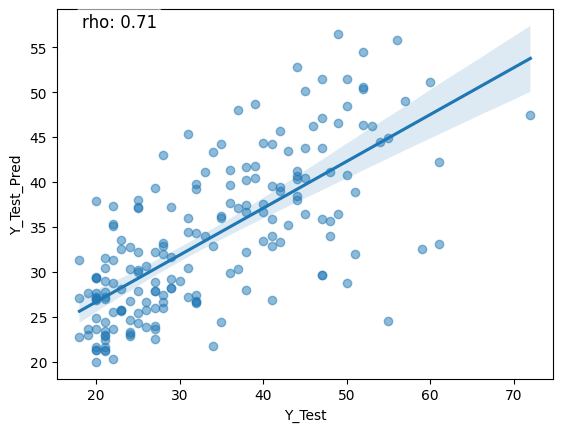

In [36]:
corr, _ = pearsonr(df_test['Y_Test'], df_test['Y_Test_Pred'])
corr_text = f'rho: {corr:.2f}'
sns.regplot(x='Y_Test', y='Y_Test_Pred', data=df_test, scatter_kws={'alpha':0.5})
plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
plt.show()

In [41]:

mape_train, r2_train, mape_test, r2_test = compute_age_mae_r2(model, std_train_loader, std_test_loader, device)
print(f"Train Age MAPE: {mape_train}, Test Age MAPE: {mape_test}.")
print(f"Train Age R2: {r2_train}, Test Age R2: {r2_test}.")

Training age estimator
Train Age MAPE: 0.042735498398542404, Test Age MAPE: 0.1925201565027237.
Train Age R2: 0.9062732358192529, Test Age R2: 0.5059181832574472.


### Learning Curve

In [38]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [55]:
estimator = AgeEstimator()
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'r2')

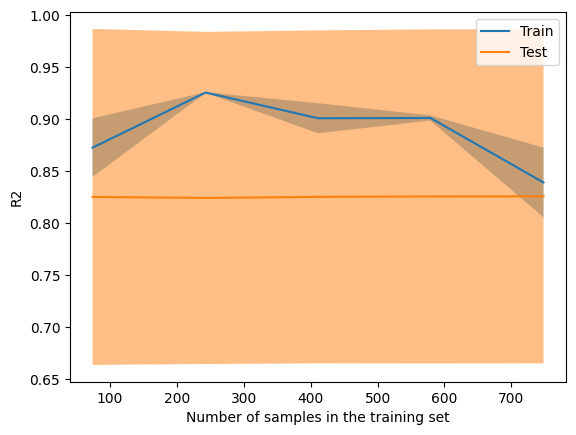

In [56]:

display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="R2")
display.plot()
plt.show()

## Train Embedding


In [42]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat = model(features)
        emb_features.append(out_feat.cpu())
        loss = criterion_pft(out_feat, targets)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   2.60


In [43]:
emb_features = torch.row_stack(emb_features)
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])
emb_features["sub"] = np.arange(1, len(emb_features) +1)

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(-1.2, 1.2)

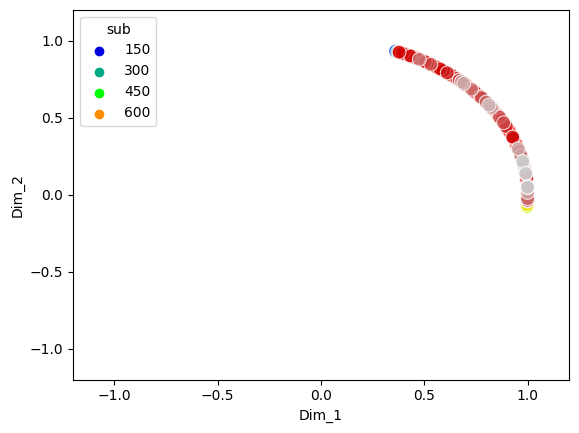

In [44]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)


## Test Embedding

In [45]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat = model(features)
        emb_features.append(out_feat.cpu())
        loss = criterion_pft(out_feat, targets)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   3.48


In [47]:
emb_features = torch.row_stack(emb_features)
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])
emb_features["sub"] = np.arange(1, len(emb_features) +1)

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(-1.2, 1.2)

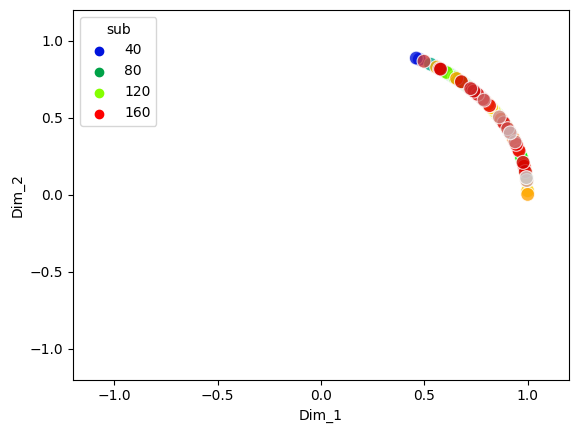

In [48]:
sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)